# Monetary Economics: Chapter 7

### Preliminaries

In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

from pysolve.model import Model
from pysolve.utils import is_close,round_solution

import matplotlib.pyplot as plt

### Model BMWK

In [2]:
def create_bmwk_model():
    model = Model()

    model.set_var_default(0)
    #model.var('AF', desc='Amortization funds')
    model.var('Cd', desc='Consumption goods demand by households')
    model.var('Cs', desc='Consumption goods supply')
    #model.var('DA', desc='Depreciation allowance')
    model.var('K', desc='Stock of capital')
    #model.var('Kt', desc='Target stock of capital')
    model.var('Ld', desc='Demand for bank loans')
    model.var('Ls', desc='Supply of bank loans')
    model.var('Id', desc='Demand for investment goods')
    model.var('Is', desc='Supply of investment goods')
    model.var('Mh', desc='Bank deposits held by households')
    model.var('Ms', desc='Supply of bank deposits')
    model.var('Nd', desc='Demand for labor')
    model.var('Ns', desc='Supply of labor')
    model.var('Rl', desc='Rate of interest on bank loans')
    model.var('Rm', desc='Rate of interest on bank deposits')
    model.var('W', desc='Wage rate')
    model.var('WBd', desc='Wage bill - demand')
    model.var('WBs', desc='Wage bill - supply')
    model.var('Y', desc='Income = GDP')
    model.var('YD', desc='Disposable income of households')
    
    ############
    model.var('rcf', desc='Fu/K(-1)')
    model.var('Ft', desc='Total Profits')
    model.var('Fu', desc='Retained earning')
    model.var('u', desc='Capacity utilization')
    
    model.set_param_default(0)
    model.param('alpha0', desc='Exogenous component in consumption')
    model.param('alpha1r', desc='Propensity to consume out of interest income')
    model.param('alpha1w', desc='Propensity to consume out of wage income')
    model.param('alpha2', desc='Propensity to consume out of wealth')
    model.param('delta', desc='Depreciation rate')
    #model.param('gamma', desc='Speed of adjustment of capital to its target value')
    model.param('kappa', desc='Capital-output ratio')
    
    #####
    model.param('gamma0', desc='Autonomous investiment')
    model.param('gamma1', desc='Sensitivity of cash-flow')
    model.param('gamma2', desc='Sensitivity leverage')
    model.param('gamma3', desc='Sensitivity of u')

    model.param('PR', desc='Labor productivity')
    model.param('Rlbar', desc='Rate of interest on bank loans, set exogenously')

    # Basic behavioural equations
    model.add('Cs = Cd') 
    model.add('Is  = Id')
    model.add('Ns = Nd')
    model.add('Ls - Ls(-1) = Ld - Ld(-1)') # Sem restrição de crédito
    model.add('Y = Cs + Is')
    #model.add('WBd = Y - Rl(-1)*Ld(-1) - AF')
    model.add('WBd = Y - Rl(-1)*Ld(-1)')
    #model.add('AF = delta * K(-1)') # Retirado
    #model.add('Ld - Ld(-1) = Id - AF') #Alterado
    model.add('rcf = Fu/K(-1)')
    model.add('Ft = Y - W') # (Sem Eq, p. 5)
    model.add('Fu = Ft - Rl*Ld(-1)') # (5)
    model.add('Ld = Id - Fu')
    model.add('u = Y/K')
    
    # Transactions of households
    model.add('YD = WBs + Rm(-1)*Mh(-1)')
    model.add('Mh - Mh(-1) = YD - Cd')
    
    # Transactions of the banks
    model.add('Ms - Ms(-1) = Ls - Ls(-1)')
    model.add('Rm = Rl')
    
    # The wage bill
    model.add('WBs = W * Ns')
    model.add('Nd = Y / PR')
    model.add('W = WBd / Nd')
    
    # Household behavior
    model.add('Cd = alpha0 + alpha1w*WBs + alpha1r*Rm(-1)*Mh(-1) + alpha2*Mh(-1)')# Retirar
    
    # The investment beahavior
    #model.add('K - K(-1) = Id - DA')
    model.add('K - K(-1) = Id')
    #model.add('DA = delta * K(-1)') # Retirado
    #model.add('Kt = kappa * Y(-1)') # Retirado
    #model.add('Id = gamma * (Kt - K(-1)) + DA') # Alterado para (21) sem q de tobin
    model.add('Id = gamma0 + gamma1*rcf(-1) - gamma2*Rlbar*Ld/K + gamma3*u(-1)')
    
    # The behaviour of banks
    model.add('Rl = Rlbar')    

    return model

bmwk_parameters = {'alpha0': 10,
                   'alpha1r': 0,
                   'alpha1w': 0.75,
                   'alpha2': 0,
                   'delta': 0.1,
                   'gamma0':10,
                   'gamma1': 0.1,
                   'gamma2': 0.1,
                   'gamma3': 0.8}
bmwk_exogenous = {'PR': 1,
                  'Rlbar': 0.05}
bmwk_variables = {'Mh': 185.2,
                  'Ms': 185.2,
                  'Ld': 185.2,
                  'Ls': 185.2,
                  'K': 185.2,
                  'Y': 185.2,
                  'Rl': 0.04,
                  'Rm' : 0.04,
                  'W': 0.86,
                  'Cd': 1,
                  'rcf':1}

### Scenario: Model BMWK, increase in the interest rate on loans

In [7]:
interest = create_bmwk_model()
interest.set_values(bmwk_parameters)
interest.set_values(bmwk_exogenous)
interest.set_values(bmwk_variables)

# run to convergence
# Give the system more time to reach a steady state
for _ in range(15):
    interest.solve(iterations=200, threshold=1e-5)

# shock the system
interest.set_values({'gamma0': 5})

for _ in range(100):
    interest.solve(iterations=10000, threshold=1e-5)

###### Figure 7.8

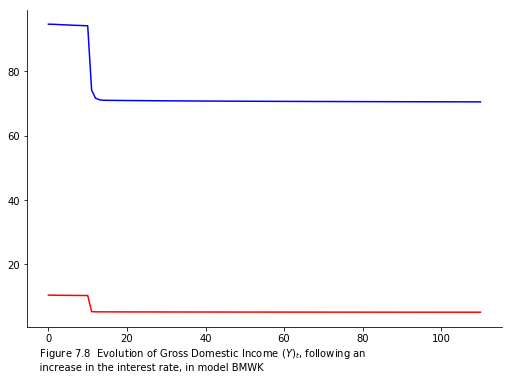

In [8]:
caption = '''
    Figure 7.8  Evolution of Gross Domestic Income $(Y)_{t}$, following an
    increase in the interest rate, in model BMWK'''
data_rcf = [s['rcf'] for s in interest.solutions[5:]]
data_l = [s['Ld'] for s in interest.solutions[5:]]
data_Y = [s['Y'] for s in interest.solutions[5:]]
data_Id = [s['Id'] for s in interest.solutions[5:]]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top=False, right=False)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
#axes.set_ylim(-1, 2)

axes.plot(data_Y, linestyle='-', color='b')
axes.plot(data_Id, linestyle='-', color='r')
# add labels
#plt.text(20, 182, 'National income')
         
fig.text(0.1, -.05, caption);